# Kriging using a predifined model
In this notebook we will revisite the kriging method for interpolation. For simplicity we will work with a given correlation model. That is, the Whittle Model taken from the FIA data.

So first thing first, import the neessary modules. Depending on your machine this may change.
For the moment I work with this.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/spystats/spystats')
sys.path.append('/apps/external_plugins/spystats')

import django
django.setup()
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')


In [2]:
import pandas as pd
from statsmodels.regression import linear_model
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import statsutils
from scipy.spatial import distance_matrix

In [3]:
import tools
import HEC_runs.fit_fia_logbiomass_logspp_GLS as auxiliary

In [4]:
## File locations, change accordingly
empirical_data_path = "/RawDataCSV/idiv_share/FIA_Plots_Biomass_11092017.csv"
variogram_path = "/apps/external_plugins/spystats/HEC_runs/results/variogram/data_envelope.csv"


## Kriging
The minimum mean square error predictor for $S(x)$ is given by:
$$\hat{S}(x) = \mu + r^{'}V^{-1}(Y - \mu)$$
Let's split this accordingly:
* $\mu = \beta X$
* res = (Y - $\mu$)


    
    

In [5]:
def _getbetaX(obsdf,beta):
    X = np.array([np.ones(len(obsdf)),obsdf.values])
    predicted_average = np.dot(beta,X)
    return predicted_average  

In [63]:
def Predict(variogram_object,predicted_dataframe,
            observed_mean_values,
            predicted_mean_values,
            response_variable="LogBiomass"):
    """
    Parameters:
        variogram_object (Variogram Instance): It needs to include the full observed data.
        predicted_dataframe (Pandas geodataframe): A geodataframe with the coordinates and covariates (if the case) to predict.
        observed_mean_values : (numpy array) the values obtained from the mean function using the observed data (train).
        predicted_mean_values : (numpy_array) the values obtained from the mean function using the predicted data.
        response_variable : (String) The name of the observed variable.
    """
    
    
    def _get_point_array(geodf):
        px = geodf.geometry.x
        py = geodf.geometry.y
        p = zip(px,py)
        ps =  map(lambda t : np.array(t),p)
        return ps
    
    
    obsvg = variogram_object
    predf = predicted_dataframe
    
    obs_p = _get_point_array(obsvg.data)
    ## predictions
    pred_p = _get_point_array(predf)
    ## Matrix distance
    R = distance_matrix(pred_p,obs_p,)
    ## With covariance
    Rn = np.array(obsvg.model.corr_f(R.flatten())) * obsvg.model.sigma2
    ## Only correlation
    #Rn = np.array(obsvg.model.corr_f(R.flatten()))
    Rn.shape = R.shape
    M = obsvg.calculateCovarianceMatrix()
    V_inv = np.linalg.inv(M)
    
    
    obsY = obsvg.data[response_variable]   
    obs_res = obsY.values - observed_mean_values
    partial = np.dot(Rn,np.dot(V_inv,obs_res))
    
    Sx = predicted_mean_values + partial
    return Sx

### Auxiliary functions
    * Open file
    * Convert it to Pandas with Geometry (GeoPandas)
    * Reproject it to Lambert Conic Conformal
    * Calculate OLS and append residuals

In [7]:
minx = -130
maxx = -60
miny = 24
maxy = 50

In [8]:
data = auxiliary.initAnalysis(empirical_data_path=empirical_data_path,plotdata_path=variogram_path, maxx=maxx,minx=minx,maxy=maxy,miny=miny)

INFO:root:Reading data
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Fitting OLS linear model: logBiomass ~ logSppN 
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Subselecting Region


### Setting the beta coefficients (obtained earlier) 
Intercept = 8.4704  
logSppN =  0.3909  


In [9]:
beta = np.array([8.4704,0.3909])

## Selecting a small region for testing
Strategy:
* take subsample to start working with it:


In [10]:
minx = -108
maxx = -106
miny = 38
maxy = 40

l =10

section = tools._subselectDataFrameByCoordinates(data,'LON','LAT',minx, maxx, miny, maxy)
model = tools.WhittleVariogram(sill=0.340246718396,range_a=41188.0234423,nugget=0.329937603763,alpha=1.12143687914)

In [11]:
obsvg = tools.Variogram(section,'residuals',model=model)

### Read the predictors.
The predictor raster has been calculated using GIS.
The procedure was as follows.
1. rasterize the points of FIA_Biomass adding the values of the points within each cell.
The resolution was 0.03 degrees. for x and y. Approx: 5 km.

2. The raster was converted to csv
3. Loaded into Pandas as predictor.
### Load the predictor data frame

In [12]:
predictors = pd.read_csv("/RawDataCSV/FIA/pred_krig.csv", names = ["Lon", "Lat", "SppN"])
predictors = tools.toGeoDataFrame(predictors,xcoord_name="Lon",ycoord_name="Lat")
## We need to reproject
predictors =  predictors.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
## Do the log of this
predictors['logSppN'] = np.log(predictors.SppN)
## we will have lim x-> 0 log(x) = -inf
## Because of how we construct absences we can substitute here all nan by 0.
predictors = predictors.replace(-np.inf,0)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [13]:
Ypredictors = pd.read_csv("/RawDataCSV/FIA/Ypred_krig.csv", names = ["Lon", "Lat", "Biomass"])
Ypredictors = tools.toGeoDataFrame(Ypredictors,xcoord_name="Lon",ycoord_name="Lat")
Ypredictors['logBiomass'] = np.log(Ypredictors.Biomass)
## Because of how we construct absences we can substitute here all nan by 0.
Ypredictors = Ypredictors.replace(-np.inf,0)

## We need to reproject
#predictors =  predictors.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
def getOuterBlockExtent(minx,maxx,miny,maxy):
    # magnitud to shrink
    shrk = 1.5
    shrink = lambda x : x + ( float(x)/abs(x) * shrk )
    shrink_inv = lambda x : x - ( float(x)/abs(x) * shrk )
    mminx = shrink(minx)
    mmaxx = shrink_inv(maxx)
    mminy = shrink_inv(miny)
    mmaxy = shrink(maxy)
    return (mminx,mmaxx,mminy,mmaxy)

In [15]:
def getInnerBlockExtent(minx,maxx,miny,maxy):
    # magnitud to shrink
    shrk = 0.5
    shrink = lambda x : x - ( float(x)/abs(x) * shrk )
    shrink_inv = lambda x : x + ( float(x)/abs(x) * shrk )
    mminx = shrink(minx)
    mmaxx = shrink_inv(maxx)
    mminy = shrink_inv(miny)
    mmaxy = shrink(maxy)
    return (mminx,mmaxx,mminy,mmaxy)

In [16]:
def PredictHere(observations_df,predictions_df,coef_meanf,model=model):
    obsvg = tools.Variogram(observations_df,'logBiomass',model=model)
    beta = coef_meanf
    obs_m_vals = _getbetaX(obsvg.data.logSppN,beta)
    pred_m_vals = _getbetaX(predictions_df.logSppN,beta)
    SSx = Predict(variogram_object=obsvg,
                  predicted_dataframe=predictions_df,
                  observed_mean_values=obs_m_vals,
                  predicted_mean_values=pred_m_vals,
                  response_variable="logBiomass")
    Sx = pd.DataFrame({'Sx' : SSx})
    Sx = Sx.set_index(predictions_df.index)
    S = pd.concat([Sx,predictions_df],axis=1)
    return S # pd.concat([predictions_df,Sx],axis=0)

In [17]:
exto = [minx,maxx,miny,maxy]
nminx,nmaxx,nminy,nmaxy = getInnerBlockExtent(*exto)
megaminx,megamaxx,megaminy,megamaxy = getOuterBlockExtent(*exto)

In [18]:
exto

[-108, -106, 38, 40]

In [19]:
[megaminx,megamaxx,megaminy,megamaxy]

[-109.5, -104.5, 36.5, 41.5]

In [20]:
[nminx,nmaxx,nminy,nmaxy]

[-107.5, -106.5, 38.5, 39.5]

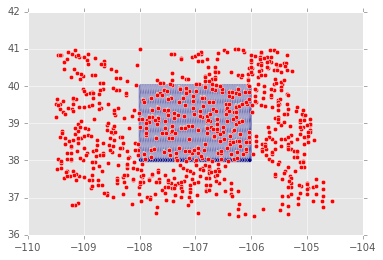

In [21]:
obsec = tools._subselectDataFrameByCoordinates(data,'LON','LAT',megaminx, megamaxx, megaminy, megamaxy)
predsec = tools._subselectDataFrameByCoordinates(predictors,'Lon','Lat',minx, maxx, miny, maxy)
plt.scatter(predsec.Lon,predsec.Lat,c=predsec.logSppN)
plt.scatter(obsec.LON,obsec.LAT,c='red')

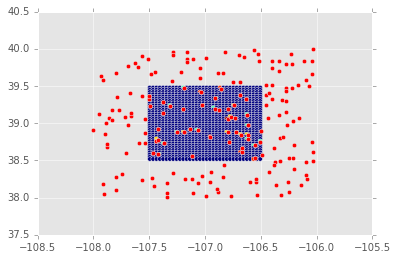

In [22]:
pred_section = tools._subselectDataFrameByCoordinates(predictors,'Lon','Lat',nminx, nmaxx, nminy, nmaxy)
plt.scatter(pred_section.Lon,pred_section.Lat,c=pred_section.logSppN)
plt.scatter(section.LON,section.LAT,c='red')

In [28]:
SSSx = PredictHere(observations_df=section,predictions_df=pred_section,coef_meanf=beta)

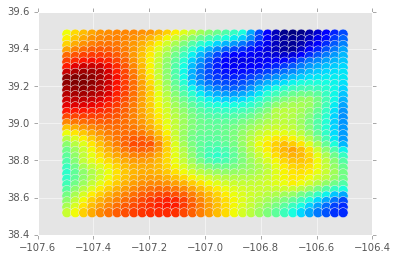

In [29]:
plt.scatter(SSSx.Lon,SSSx.Lat,c=SSSx.Sx, s=100)
#plt.scatter(section.LON,section.LAT,c='red')

## Ahora hagamos una partici'on sobre el extetn de us.


In [30]:
gminx = data.LON.min()
gmaxx = data.LON.max()
gminy = data.LAT.min()
gmaxy = data.LAT.max()

In [34]:
## Let's build the partition
N = 10
xp,dx = np.linspace(gminx,gmaxx,N,retstep=True)
yp,dy = np.linspace(gminy,gmaxy,N,retstep=True)


In [35]:
xx,yy = np.meshgrid(xp,yp)

In [36]:
coordinates_list = [ (xx[i][j],yy[i][j]) for i in range(N) for j in range(N)]

In [37]:
from functools import partial
tuples = map(lambda (x,y) : partial(tools._getExtentFromPoint,x,y,step_sizex=dx,step_sizey=dy)(),coordinates_list)

## Hacer el chunks pero a los minichunks, aunque haya overlap


In [38]:
megatuples = map(lambda tup : getOuterBlockExtent(*tup),tuples)
#megatuples = map(lambda tup : getInnerBlockExtent(*tup),tuples)

In [39]:
observed_chunks = map(lambda (mx,Mx,my,My) : 
                      tools._subselectDataFrameByCoordinates(data,'LON','LAT',mx,Mx,my,My),
                      megatuples)

In [40]:
predictive_chunks = map(lambda (mx,Mx,my,My) : 
                        tools._subselectDataFrameByCoordinates(predictors,'Lon','Lat',mx,Mx,my,My),
                        tuples)

In [41]:
chunks = zip(observed_chunks,predictive_chunks)

In [42]:
non = filter(lambda (obs,pred): ((obs.shape[0] != 0) and (pred.shape[0] != 0 )), chunks)

In [43]:
tuples[1]

(-118.280014, -111.875135, 24.665523999999998, 27.408121888888886)

In [44]:
megatuples[1]

(-119.780014, -110.375135, 23.165523999999998, 28.908121888888886)

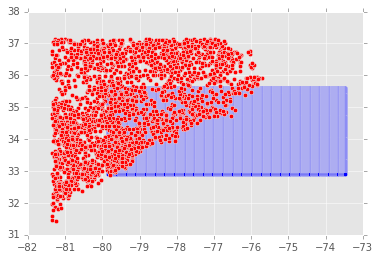

In [45]:
c = non[26]
#c = chunks[3]
obs,pred = c
plt.scatter(pred.Lon,pred.Lat)
plt.scatter(obs.LON,obs.LAT,c='red')

In [ ]:
len(non)

In [59]:
%time surfaces = map(lambda (o,p) : PredictHere(observations_df=o,predictions_df=p,coef_meanf=beta),non)

CPU times: user 9min 52s, sys: 1min 13s, total: 11min 5s
Wall time: 8min 45s


In [60]:
totsurf = pd.concat(surfaces)

In [61]:
totsurf['PredBiomass'] = np.exp(totsurf.Sx.values)

In [50]:
#plt.scatter(totsurf.Lon,totsurf.Lat,c=totsurf.Sx, s=1)

In [64]:
totsurf.to_csv("/outputs/predicted_kriging_biomass.csv")

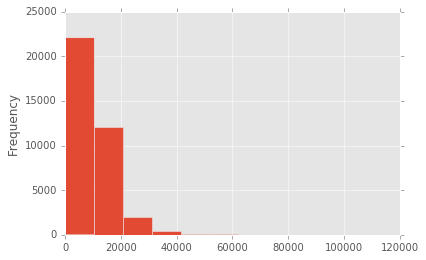

In [73]:
data.plotBiomass.plot.hist()

In [71]:
data.columns

Index([    u'STATECD',     u'STATENM',     u'STATEAB',    u'COUNTYCD',
              u'PLOT',     u'PLOT_ID',     u'PlotIDn',         u'LAT',
               u'LON',       u'INVYR',   u'N_subplot',    u'StandAge',
       u'treeDensity',      u'plotBA', u'plotBiomass',        u'SppN',
          u'geometry',  u'logBiomass',      u'newLon',      u'newLat',
           u'logSppN',   u'residuals'],
      dtype='object')

In [ ]:
## Steps
1) Hacer una grid, y predictores (listo)
2) El predictor debe ser presencia ausencia de richeza y talvez usar la suma (listo)
3) generar la matriz extendida
    1. Hacer blockes anidados
    2.  extraer datos y generar matriz
4) Applicar modelo de kriging
5) moverse al siguienate chunck


In [ ]:
obsvg = tools.Variogram(section,'residuals',model=model)